In [1]:
#import potrebnih biblioteka
%matplotlib inline
import cv2
import numpy as np 
import matplotlib.pyplot as plt 
import collections

#from __future__ import print_function
np.random.seed(1337)  # for reproducibility

#keras - za neuronsku mrezu
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

In [64]:
#Pomocne funkcije(sa vezbi)
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=2)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=2)
def resize_region(region):
    '''Transformisati selektovani region na sliku dimenzija 28x28'''
    return cv2.resize(region,(28,28), interpolation = cv2.INTER_LANCZOS4)
def select_roi(image_orig, image_bin):
    '''Oznaciti regione od interesa na originalnoj slici. (ROI = regions of interest)
        Za svaki region napraviti posebnu sliku dimenzija 28 x 28. 
        Za označavanje regiona koristiti metodu cv2.boundingRect(contour).
        Kao povratnu vrednost vratiti originalnu sliku na kojoj su obeleženi regioni
        i niz slika koje predstavljaju regione sortirane po rastućoj vrednosti x ose
    '''
    img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = [] # lista sortiranih regiona po x osi (sa leva na desno)
    regions_dic = {}
    for contour in contours: 
        x,y,w,h = cv2.boundingRect(contour) #koordinate i velicina granicnog pravougaonika
        area = cv2.contourArea(contour)
        #if area > 100 and h < 100 and h > 5 and w > 15:
        if area > 100 and area < 16000 and h < 400 and h > 80 and w > 10 and w<400:
            # kopirati [y:y+h+1, x:x+w+1] sa binarne slike i smestiti u novu sliku
            # označiti region pravougaonikom na originalnoj slici (image_orig) sa rectangle funkcijom
            region = image_bin[y-30:y+h+31,x-30:x+w+31];
            regions_dic[x] = resize_region(region)       
            cv2.rectangle(image_orig,(x,y),(x+w,y+h),(0,255,0),2)
    
    sorted_regions_dic = collections.OrderedDict(sorted(regions_dic.items()))
    sorted_regions = sorted_regions_dic.values()
            
    # sortirati sve regione po x osi (sa leva na desno) i smestiti u promenljivu sorted_regions
    return image_orig, sorted_regions
def scale_to_range(image): # skalira elemente slike na opseg od 0 do 1
    ''' Elementi matrice image su vrednosti 0 ili 255. 
        Potrebno je skalirati sve elemente matrica na opseg od 0 do 1
    '''
    return image/255
def matrix_to_vector(image):
    '''Sliku koja je zapravo matrica 28x28 transformisati u vektor sa 784 elementa'''
    return image.flatten()
def prepare_for_ann(regions):
    '''Regioni su matrice dimenzija 28x28 čiji su elementi vrednosti 0 ili 255.
        Potrebno je skalirati elemente regiona na [0,1] i transformisati ga u vektor od 784 elementa '''
    ready_for_ann = []
    for region in regions:
        # skalirati elemente regiona (metoda iz TODO 3 scale_to_range)
        # region sa skaliranim elementima pretvoriti u vektor (metoda iz TODO 4 matrix_to_vector)
        # vektor dodati u listu spremnih regiona
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))
        
    return ready_for_ann
def convert_output(alphabet):
    '''Konvertovati alfabet u niz pogodan za obučavanje NM,
        odnosno niz čiji su svi elementi 0 osim elementa čiji je
        indeks jednak indeksu elementa iz alfabeta za koji formiramo niz.
        Primer prvi element iz alfabeta [1,0,0,0,0,0,0,0,0,0],
        za drugi [0,1,0,0,0,0,0,0,0,0] itd..
    '''
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))
        output[index] = 1
        nn_outputs.append(output)
    return np.array(nn_outputs)
def winner(output): # output je vektor sa izlaza neuronske mreze
    '''pronaći i vratiti indeks neurona koji je najviše pobuđen'''
    return max(enumerate(output), key=lambda x: x[1])[0]

def display_result(outputs, alphabet):
    '''za svaki rezultat pronaći indeks pobedničkog
        regiona koji ujedno predstavlja i indeks u alfabetu.
        Dodati karakter iz alfabet u result'''
    result = []
    for output in outputs:
        result.append(alphabet[winner(output)])
    return result

In [3]:
#import obucavajuceg skupa - MNIST

batch_size = 128
nb_classes = 10
nb_epoch = 20

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#display_image(X_train[674])
Temp_X_train = X_train
Temp_X_test = X_test

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print X_train.shape[0], 'train samples'
print X_test.shape[0], 'test samples'

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

60000 train samples
10000 test samples


In [4]:
#funkcije za kreiranje i treniranje NM
def create_ann():
    '''Implementacija veštačke neuronske mreže sa 784 neurona na uloznom sloju,
        128 neurona u skrivenom sloju i 10 neurona na izlazu. Aktivaciona funkcija je sigmoid.
    '''
    ann = Sequential()
    ann.add(Dense(512, input_dim=784, activation='sigmoid'))
    ann.add(Dense(10, activation='sigmoid'))
    return ann
    
def train_ann(ann, X_train, y_train):
    '''Obucavanje vestacke neuronske mreze'''
    X_train = np.array(X_train, np.float32) # dati ulazi
    y_train = np.array(y_train, np.float32) # zeljeni izlazi za date ulaze
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    #rms = RMSprop()
    #ann.compile(loss='mean_squared_error', optimizer=rms)
    
    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, nb_epoch=20, batch_size=128, verbose = 2,show_accuracy=True) 
      
    return ann

In [44]:
#kreiranje i treniranje NM
ann = create_ann()
ann = train_ann(ann,X_train,Y_train)

Epoch 1/20
11s - loss: 0.0905 - acc: 0.2581
Epoch 2/20
10s - loss: 0.0842 - acc: 0.4131
Epoch 3/20
10s - loss: 0.0786 - acc: 0.5244
Epoch 4/20
10s - loss: 0.0724 - acc: 0.6117
Epoch 5/20
10s - loss: 0.0663 - acc: 0.6684
Epoch 6/20
10s - loss: 0.0607 - acc: 0.7069
Epoch 7/20
10s - loss: 0.0560 - acc: 0.7364
Epoch 8/20
10s - loss: 0.0521 - acc: 0.7602
Epoch 9/20
10s - loss: 0.0488 - acc: 0.7795
Epoch 10/20
10s - loss: 0.0461 - acc: 0.7936
Epoch 11/20
10s - loss: 0.0439 - acc: 0.8059
Epoch 12/20
10s - loss: 0.0419 - acc: 0.8158
Epoch 13/20
10s - loss: 0.0402 - acc: 0.8227
Epoch 14/20
11s - loss: 0.0388 - acc: 0.8298
Epoch 15/20
16s - loss: 0.0375 - acc: 0.8347
Epoch 16/20
13s - loss: 0.0363 - acc: 0.8399
Epoch 17/20
15s - loss: 0.0353 - acc: 0.8440
Epoch 18/20
13s - loss: 0.0343 - acc: 0.8466
Epoch 19/20
12s - loss: 0.0335 - acc: 0.8495
Epoch 20/20
13s - loss: 0.0327 - acc: 0.8519


In [76]:
#Izracunavanje rezultata
rezultat = ann.predict(np.array(numbers,np.float32))

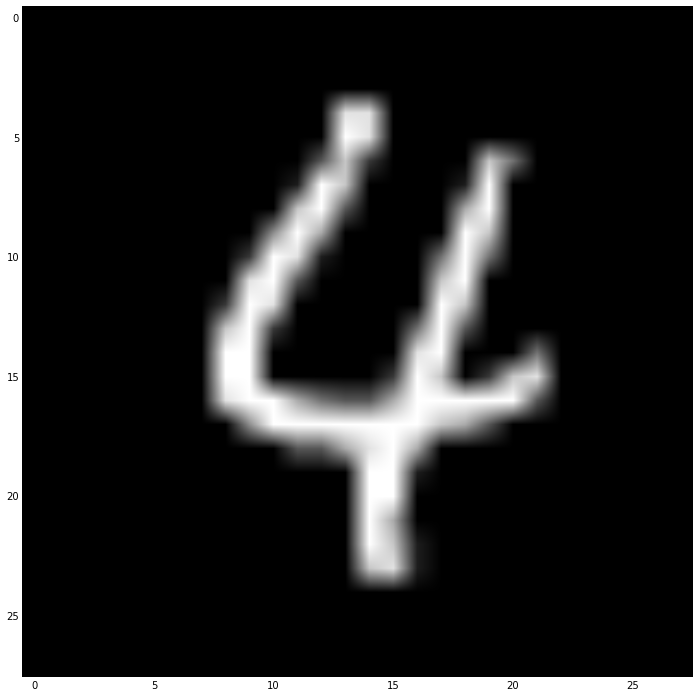

In [196]:
#print rezultat[0]
temp_X_test = Temp_X_test[100:110]
display_image(temp_X_test[9])

In [48]:
alphabet = [0,1,2,3,4,5,6,7,8,9]

In [77]:
print rezultat[0]
display_result(rezultat,alphabet)

[ 0.01775296  0.09492579  0.03075204  0.03980986  0.27360188  0.14430882
  0.05152834  0.10901908  0.02351339  0.1206909 ]


[4, 1, 1, 1]

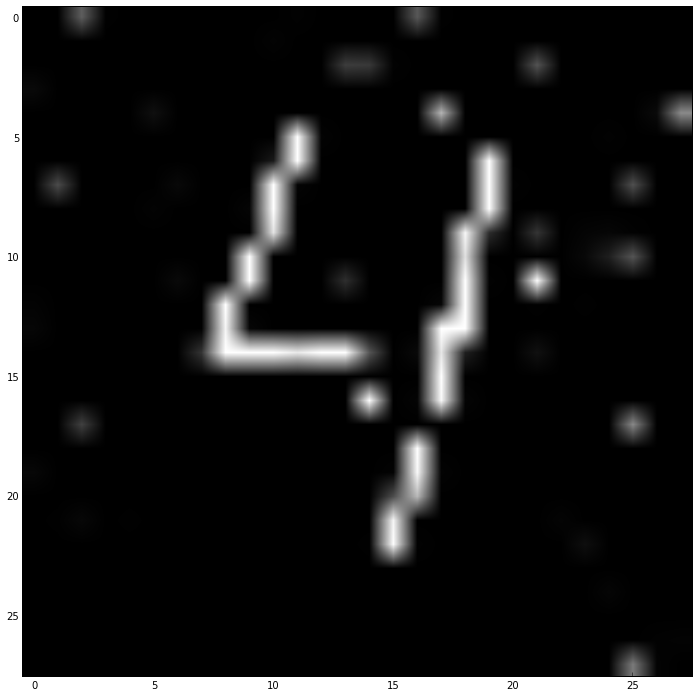

In [72]:
#Ucitavanje slike(slika nije iz MNIST-ovih testnih primera)
image_ada = cv2.imread('test_images/ltcam.jpg')
image_ada = cv2.cvtColor(image_ada, cv2.COLOR_BGR2GRAY)
image_ada_bin = cv2.adaptiveThreshold(image_ada, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, 5)
img = invert(image_ada_bin)
img = erode(dilate(img))

selected_regions, numbers = select_roi(image_ada.copy(), img)
display_image(numbers[0])
numbers = prepare_for_ann(numbers)

In [52]:
cap = cv2.VideoCapture(1)

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Our operations on the frame come here
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    image_ada_bin = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, 5)
    img = invert(image_ada_bin)
    img = erode(dilate(img))

    #img, contours, hierarchy = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #selected_regions, numbers = select_roi(gray.copy(), img)
    #contours_sb = []
    #for contour in contours:
    #    area = cv2.contourArea(contour)
    #    if area > 100 and area < 500:
    #        contours_sb.append(contour)

    #image_sb_contours = frame.copy()
    #cv2.drawContours(image_sb_contours, contours_sb, -1, (255,0,0), 1)
    
    # Display the resulting frame
    cv2.imshow('frame',img)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()